# ScaleOut Exercise

**NOTE: If you got an error saying `hats-sci-pi` doesn't exist, close and halt this notebook and run the 1-pyroot-setup notebook, then come back and change the kernel of this notebook back to `hats-sci-pi`**

One important component of scaling out computation is decomposing it into smaller independent chunks, which can then be executed on multiple resources simultaneously. Let's do this on a simplified example to see what this looks like and what can go wrong

In [91]:
import ROOT as r
r.gDebug = 0
import json
import pprint
import random
from ConfigParser import RawConfigParser
config = RawConfigParser()   
config.optionxform = str       # Last two lines are done because ConfigParser will not preserve case
config.read("hatsConfig.ini")
fullCrossSections = dict([sample, float(xsec)] for sample, xsec in config.items('hatsXsects'))
nProcessed    = dict([sample, int(nPro)] for sample, nPro in config.items('hatsNprocessed'))
varNames=['dijetEtBalance', 'dijetMass']
fileList = json.loads(open("filelist.json").read())
fullHatsChains = {}
shortHatsChains = {}
for sample in fileList.keys():
    chain = r.TChain('hatsDijets')
    shortChain = r.TChain('hatsDijets')
    random.shuffle(fileList[sample])
    sampleList = fileList[sample]
    shortChain.Add("/mnt/hdfs/" + sampleList[0])
    for hatsFile in sampleList:
        chain.Add("/mnt/hdfs/" + hatsFile)
    fullHatsChains[sample] = chain
    shortHatsChains[sample] = shortChain

### Change this to either run the full or short data
As you're debugging, it can help to run on a shortened dataset

In [58]:
hatsChains = fullHatsChains ; crossSections = fullCrossSections
#hatsChains = shortHatsChains ; crossSections = dict(fullCrossSections.items()[:2])

## An "Analysis"
To give us something to work with, consider the analysis below. This code will plot several kinematics from multiple samples, then store the histograms in a variable named "hist".

This is obviously trivial (and incredibly slow), but the "meat" of the analysis isn't what's important, it's the decomposition we care about. Looking at this code, what can be pulled apart?

Time elapsed: 20.46secs
{'dijetEtBalance_QCD_HT1000to1500': <ROOT.TH1F object ("dijetEtBalance_QCD_HT1000to1500") at 0x6c887b0>,
 'dijetEtBalance_QCD_HT1500to2000': <ROOT.TH1F object ("dijetEtBalance_QCD_HT1500to2000") at 0x6c4ca40>,
 'dijetEtBalance_QCD_HT2000toInf': <ROOT.TH1F object ("dijetEtBalance_QCD_HT2000toInf") at 0x6c8bd40>,
 'dijetEtBalance_QCD_HT300to500': <ROOT.TH1F object ("dijetEtBalance_QCD_HT300to500") at 0x6c74f50>,
 'dijetEtBalance_QCD_HT500to700': <ROOT.TH1F object ("dijetEtBalance_QCD_HT500to700") at 0x6bd79b0>,
 'dijetEtBalance_QCD_HT700to1000': <ROOT.TH1F object ("dijetEtBalance_QCD_HT700to1000") at 0xc867dc0>,
 'dijetMass_QCD_HT1000to1500': <ROOT.TH1F object ("dijetMass_QCD_HT1000to1500") at 0xc83f410>,
 'dijetMass_QCD_HT1500to2000': <ROOT.TH1F object ("dijetMass_QCD_HT1500to2000") at 0x6c76e10>,
 'dijetMass_QCD_HT2000toInf': <ROOT.TH1F object ("dijetMass_QCD_HT2000toInf") at 0xc8b2220>,
 'dijetMass_QCD_HT300to500': <ROOT.TH1F object ("dijetMass_QCD_HT300to500")

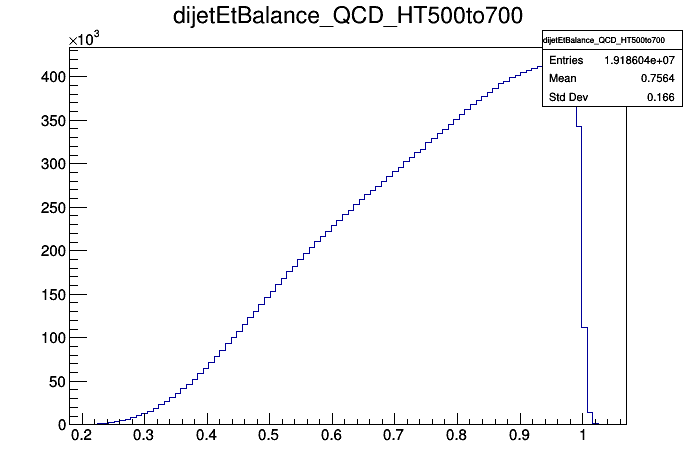

In [80]:
hists = {}
import time
tic = time.time()
for sample in crossSections.keys():
    for varName in varNames:
        hatsChains[sample].SetBranchStatus('*', 0)
        hatsChains[sample].SetBranchStatus(varName, 1)
        histLabel = "%s_%s" % (varName, sample)
        hists[histLabel]=r.TH1F(histLabel, histLabel, 100, 0, 0)
        hatsChains[sample].Draw("%s>>%s" % (varName, histLabel))
toc = time.time()
print("Time elapsed: %0.2fsecs" % (toc - tic))
pprint.pprint(hists)
canvas = r.TCanvas()
hists['dijetEtBalance_QCD_HT500to700'].Draw()
canvas.Draw()



## The technique
One method of decomposition is to separate a loop from its body, so the body can be explicitly run elsewhere and still produce the same results.

It's important that the decomposed body doesn't change or access any global state (think about why that's necessary to scale out on multiple CPUs or machines). What in the body of this loop should be changed?

In [23]:
vals = {}
tic = time.time()
for x in range(8):
    time.sleep(1)
    vals[x] = x ** 2
toc = time.time()
print("Time elapsed: %0.2fsecs" % (toc - tic))
print(vals)

Time elapsed: 8.01secs
{0: 0, 1: 1, 2: 4, 3: 9, 4: 16, 5: 25, 6: 36, 7: 49}


# Parallelizing
With some thought, we can decompose the body of our loop into a new function `sleep_some`.

Note that there was two changes made:
1. The loop variable `x`, which is normally implicitly passed from the loop into the body is turned into an explicit argument of our new function.
2. Instead of modifying `vals` to return data from the body of the loop, we pass it back to the caller as a return value.

Once we have our new function, we can then use `concurrent.futures`'s `ThreadPoolExecutor` to execute all 8 of our loop bodies in separate threads at the same time, which should mean it runs 8 times as fast as before.

In [32]:
# Split our "important" code into a separate function
def sleep_some(x):
    time.sleep(1)
    return (x, x ** 2)

# Make a thread pool to execute it
import concurrent.futures
tic = time.time()   
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as p:
    # Run one copy of every function on a separate thread simultaneously
    ret = p.map(sleep_some, range(8))
# Convert our return value into a dict to match the output from the previous cell
vals = dict(ret)
toc = time.time()
print("Time elapsed: %0.2fsecs" % (toc - tic))
print(vals)

Time elapsed: 1.02secs
{0: 0, 1: 1, 2: 4, 3: 9, 4: 16, 5: 25, 6: 36, 7: 49}


## Your turn

Following the pattern above, decompose our "analysis" to use multiple threads. Once you have it debugged, run both the original and modified versions with the full dataset and compare the runtimes. Make sure the outputs are the same!

Time elapsed: 19.84secs
{'QCD_HT1000to1500': {'dijetEtBalance_QCD_HT1000to1500': <ROOT.TH1F object ("dijetEtBalance_QCD_HT1000to1500") at 0x7f5b4c063160>,
                      'dijetMass_QCD_HT1000to1500': <ROOT.TH1F object ("dijetMass_QCD_HT1000to1500") at 0x7f5b4c096a90>},
 'QCD_HT1500to2000': {'dijetEtBalance_QCD_HT1500to2000': <ROOT.TH1F object ("dijetEtBalance_QCD_HT1500to2000") at 0x7f5b680ddb20>,
                      'dijetMass_QCD_HT1500to2000': <ROOT.TH1F object ("dijetMass_QCD_HT1500to2000") at 0x7f5b680cfe60>},
 'QCD_HT2000toInf': {'dijetEtBalance_QCD_HT2000toInf': <ROOT.TH1F object ("dijetEtBalance_QCD_HT2000toInf") at 0x7f5b500060c0>,
                     'dijetMass_QCD_HT2000toInf': <ROOT.TH1F object ("dijetMass_QCD_HT2000toInf") at 0x7f5b50006e00>},
 'QCD_HT300to500': {'dijetEtBalance_QCD_HT300to500': <ROOT.TH1F object ("dijetEtBalance_QCD_HT300to500") at 0x7f5b50007300>,
                    'dijetMass_QCD_HT300to500': <ROOT.TH1F object ("dijetMass_QCD_HT300to500") at 

Warning in <TROOT::Append>: Replacing existing TH1: dijetEtBalance_QCD_HT500to700 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dijetMass_QCD_HT500to700 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dijetEtBalance_QCD_HT700to1000 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dijetMass_QCD_HT700to1000 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dijetEtBalance_QCD_HT1000to1500 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dijetMass_QCD_HT1000to1500 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dijetEtBalance_QCD_HT1500to2000 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dijetMass_QCD_HT1500to2000 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dijetEtBalance_QCD_HT2000toInf (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing

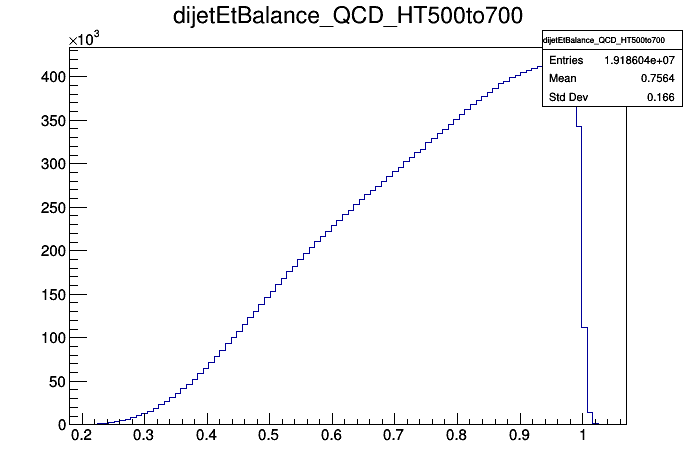

In [95]:
def kin(sample):
    hists={}
    for varName in varNames:
        hatsChains[sample].SetBranchStatus('*', 0)
        hatsChains[sample].SetBranchStatus(varName, 1)
        histLabel = "%s_%s" % (varName, sample)
        hists[histLabel]=r.TH1F(histLabel, histLabel, 100, 0, 0)
        hatsChains[sample].Draw("%s>>%s" % (varName, histLabel))
    return (sample, hists)


import time
tic = time.time()

import concurrent.futures 
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as p:
    # Run one copy of every function on a separate thread simultaneously
    ret = p.map(kin, crossSections.keys())

hists=dict(ret)
toc = time.time()
print("Time elapsed: %0.2fsecs" % (toc - tic))
pprint.pprint(hists)
canvas = r.TCanvas()
hists['QCD_HT500to700']['dijetEtBalance_QCD_HT500to700'].Draw()
canvas.Draw()

Time elapsed: 4.87secs
{'dijetEtBalance_QCD_HT1000to1500': <ROOT.TH1F object ("dijetEtBalance_QCD_HT1000to1500") at 0x7f5b6809b2a0>,
 'dijetEtBalance_QCD_HT1500to2000': <ROOT.TH1F object ("dijetEtBalance_QCD_HT1500to2000") at 0x7f5b68043790>,
 'dijetEtBalance_QCD_HT2000toInf': <ROOT.TH1F object ("dijetEtBalance_QCD_HT2000toInf") at 0x7f5b680d91c0>,
 'dijetEtBalance_QCD_HT300to500': <ROOT.TH1F object ("dijetEtBalance_QCD_HT300to500") at 0x7f5b6803c0f0>,
 'dijetEtBalance_QCD_HT500to700': <ROOT.TH1F object ("dijetEtBalance_QCD_HT500to700") at 0x7f5b6803ba50>,
 'dijetEtBalance_QCD_HT700to1000': <ROOT.TH1F object ("dijetEtBalance_QCD_HT700to1000") at 0x7f5b6803a670>,
 'dijetMass_QCD_HT1000to1500': <ROOT.TH1F object ("dijetMass_QCD_HT1000to1500") at 0x7f5b680d9f00>,
 'dijetMass_QCD_HT1500to2000': <ROOT.TH1F object ("dijetMass_QCD_HT1500to2000") at 0x7f5b680430f0>,
 'dijetMass_QCD_HT2000toInf': <ROOT.TH1F object ("dijetMass_QCD_HT2000toInf") at 0x7f5b68039fd0>,
 'dijetMass_QCD_HT300to500': <R

Warning in <TROOT::Append>: Replacing existing TH1: dijetEtBalance_QCD_HT500to700 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dijetMass_QCD_HT500to700 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dijetEtBalance_QCD_HT700to1000 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dijetMass_QCD_HT700to1000 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dijetEtBalance_QCD_HT1000to1500 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dijetMass_QCD_HT1000to1500 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dijetEtBalance_QCD_HT1500to2000 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dijetMass_QCD_HT1500to2000 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dijetEtBalance_QCD_HT2000toInf (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing

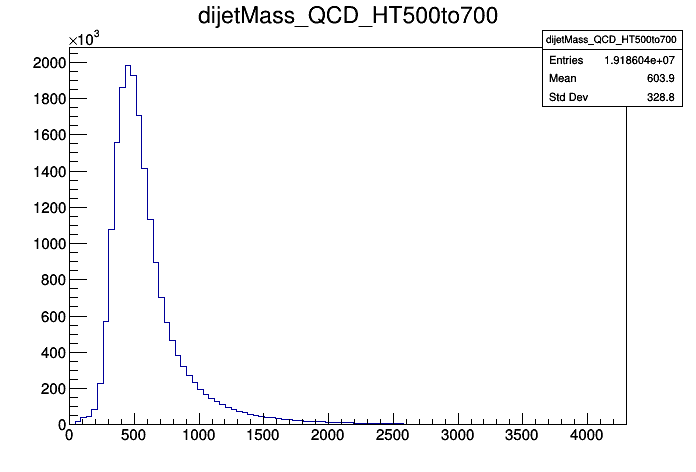

In [118]:
import time
import concurrent.futures
hists={}

def kin(item):
    sample, varName = item
    hatsChains[sample].SetBranchStatus('*', 0)
    hatsChains[sample].SetBranchStatus(varName, 1)
    histLabel = "%s_%s" % (varName, sample)
    varhist=r.TH1F(histLabel, histLabel, 100, 0, 0)
    hatsChains[sample].Draw("%s>>%s" % (varName, histLabel))
    return (histLabel, varhist)

tic = time.time()
 
with concurrent.futures.ProcessPoolExecutor(max_workers=8) as p:
    # Run one copy of every function on a separate thread simultaneously
    hists=dict(p.map(kin, [(s,v) for s in crossSections.keys() for v in varNames]))
                      
toc=time.time()
print("Time elapsed: %0.2fsecs" % (toc - tic))
pprint.pprint(hists)
canvas = r.TCanvas()
hists['dijetMass_QCD_HT500to700'].Draw()
canvas.Draw()

{'dijetEtBalance_QCD_HT1000to1500': <ROOT.TH1F object ("dijetEtBalance_QCD_HT1000to1500") at 0x7f5b68027400>,
 'dijetEtBalance_QCD_HT1500to2000': <ROOT.TH1F object ("dijetEtBalance_QCD_HT1500to2000") at 0x7f5b4c063020>,
 'dijetEtBalance_QCD_HT2000toInf': <ROOT.TH1F object ("dijetEtBalance_QCD_HT2000toInf") at 0x7f5b70008940>,
 'dijetEtBalance_QCD_HT300to500': <ROOT.TH1F object ("dijetEtBalance_QCD_HT300to500") at 0x7f5b5402f090>,
 'dijetEtBalance_QCD_HT500to700': <ROOT.TH1F object ("dijetEtBalance_QCD_HT500to700") at 0x7f5b500011b0>,
 'dijetEtBalance_QCD_HT700to1000': <ROOT.TH1F object ("dijetEtBalance_QCD_HT700to1000") at 0x7f5b50018100>,
 'dijetMass_QCD_HT1000to1500': <ROOT.TH1F object ("dijetMass_QCD_HT1000to1500") at 0x7f5b54004880>,
 'dijetMass_QCD_HT1500to2000': <ROOT.TH1F object ("dijetMass_QCD_HT1500to2000") at 0x7f5b50007000>,
 'dijetMass_QCD_HT2000toInf': <ROOT.TH1F object ("dijetMass_QCD_HT2000toInf") at 0x7f5b68026700>,
 'dijetMass_QCD_HT300to500': <ROOT.TH1F object ("dijet

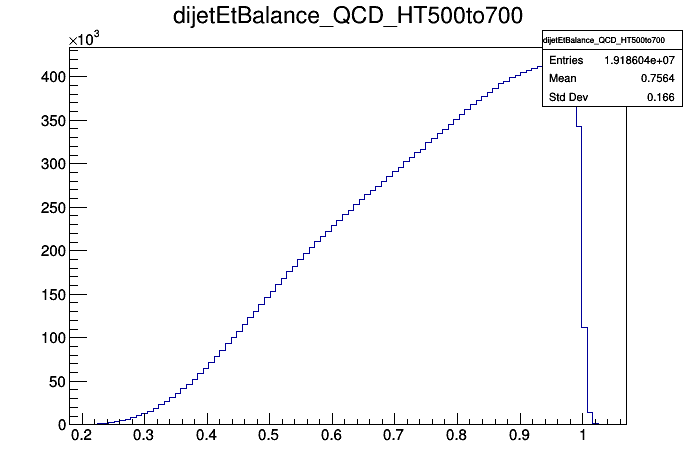

In [110]:
#Nick modified code
def run(sample, varName):
    hatsChains[sample].SetBranchStatus('*', 0)
    hatsChains[sample].SetBranchStatus(varName, 1)
    histLabel = "%s_%s" % (varName, sample)
    h = r.TH1F(histLabel, histLabel, 100, 0, 0)
    hatsChains[sample].Draw("%s>>%s" % (varName, histLabel))
    return (histLabel, h)

with concurrent.futures.ThreadPoolExecutor(max_workers=8) as p:
    work = []
    for sample in crossSections.keys():
        for varName in varNames:
            work.append(p.submit(run, sample, varName))
    
    concurrent.futures.wait(work)
    hists = dict(w.result() for w in work)

pprint.pprint(hists)
canvas = r.TCanvas()
hists['dijetEtBalance_QCD_HT500to700'].Draw()
canvas.Draw()

### What happened?

In [ ]:
# Split our "important" code into a separate function
def sleep_some(x):
    time.sleep(1)
    return (x, x ** 2)


# Make a thread pool
import concurrent.futures    
tic = time.time()   
with concurrent.futures.ProcessPoolExecutor(max_workers=8) as p:
    # Run one copy of every function on a separate thread simultaneously
    ret = p.map(sleep_some, range(8))

toc = time.time()
print("Time elapsed: %0.2fsecs" % (toc - tic))
print(dict(ret))